In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F


outputs = []

def hook_fn(module, input, output):
    outputs.append(output)

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=8, in_channels=1, emb_dim=128):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (48 // patch_size) ** 3
        self.proj = nn.Linear(patch_size**3 * in_channels, emb_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, emb_dim))

    def forward(self, x):
        # x shape: (n, 1, 48, 48, 48)
        n, c, d, h, w = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).unfold(4, self.patch_size, self.patch_size)
        x = x.contiguous().view(n, -1, c*self.patch_size**3)
        x = self.proj(x)
        x = x + self.pos_embed
        return x
    
# output1 = PatchEmbedding()(input_cube)
# print(output1.shape)

class ParameterEmbedding(nn.Module):
    def __init__(self, param_dim=3, emb_dim=128):
        super(ParameterEmbedding, self).__init__()
        self.fc = nn.Linear(param_dim, emb_dim)

    def forward(self, params):
        # params shape: (n, 3)
        param_emb = self.fc(params)
        return param_emb.unsqueeze(1)  # shape: (n, 1, emb_dim)
    
# output2 = ParameterEmbedding()(input_params)
# print(output2.shape)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, emb_dim=128, num_heads=8, ff_dim=256):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(emb_dim, num_heads)
        self.fc1 = nn.Linear(emb_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, emb_dim)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + attn_output
        x = self.norm1(x)
        ff_output = self.fc2(F.relu(self.fc1(x)))
        x = x + ff_output
        x = self.norm2(x)
        return x

# output3 = TransformerEncoderLayer()(output1)
# print(output3.shape)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='circular'),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='circular'),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, param_dim=3, base_filters=32):
        super(UNet3D, self).__init__()
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, base_filters)
        self.enc2 = DoubleConv(base_filters, base_filters * 1)
        self.enc3 = DoubleConv(base_filters * 1, base_filters * 2)
        self.enc4 = DoubleConv(base_filters * 2, base_filters * 4)

        self.pool = nn.MaxPool3d(2)

        # Bottleneck (where we will integrate parameters)
        self.bottleneck = DoubleConv(131, base_filters * 16)

        # Decoder
        self.upconv4 = nn.ConvTranspose3d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(base_filters * 10, base_filters * 8)
        
        self.upconv3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(base_filters * 5, base_filters * 4)
        
        self.upconv2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(base_filters * 3, base_filters * 2)
        
        self.upconv1 = nn.ConvTranspose3d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_filters * 1, base_filters)
        
        self.final_conv = nn.Conv3d(base_filters, out_channels, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x, params):
        
        # Encoder
        enc1 = self.enc1(x)   # shape: (n, 32, 48, 48, 48)
        enc2 = self.enc2(self.pool(enc1))  # shape: (n, 64, 24, 24, 24)
        enc3 = self.enc3(self.pool(enc2))  # shape: (n, 128, 12, 12, 12)
        enc4 = self.enc4(self.pool(enc3))  # shape: (n, 256, 6, 6, 6)

        # Integrating input parameters in bottleneck
        n, c, d, h, w = enc4.shape
        params = params.view(n, -1, 1, 1, 1).repeat(1, 1, d, h, w)
        bottleneck_input = torch.cat([enc4, params], dim=1)  # Concatenate params to feature maps
        bottleneck = self.bottleneck(bottleneck_input)  # shape: (n, 512, 6, 6, 6)
        
        # DecoderThe model was ran for 100 epochs and 7203 data points and the changes were observed with different epochs

        dec4 = self.upconv4(bottleneck)  # shape: (n, 256, 12, 12, 12)
        dec4 = self.dec4(torch.cat([dec4, enc3], dim=1))
        
        dec3 = self.upconv3(dec4)  # shape: (n, 128, 24, 24, 24)
        dec3 = self.dec3(torch.cat([dec3, enc2], dim=1))
        
        dec2 = self.upconv2(dec3)  # shape: (n, 64, 48, 48, 48)
        dec2 = self.dec2(torch.cat([dec2, enc1], dim=1))
        
        dec1 = self.upconv1(dec2)  # shape: (n, 32, 48, 48, 48)
        dec1 = self.dec1(dec1)
        
        output = self.final_conv(dec1)  # shape: (n, 1, 48, 48, 48)
        return output

class CosmoUiT(nn.Module):
    def __init__(self, patch_size=6, emb_dim=128, num_heads=4, num_layers=4, param_dim=3):
        super(CosmoUiT, self).__init__()
        self.patch_embed = PatchEmbedding(patch_size, emb_dim=emb_dim)
        self.param_embed = ParameterEmbedding(param_dim, emb_dim)
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(emb_dim, num_heads) for _ in range(num_layers)])
        self.fc_out = nn.Linear(emb_dim, patch_size**3)
        self.unet = UNet3D()

    def forward(self, x, params):#The model was ran for 100 epochs and 7203 data points and the changes were observed with different epochs

        x = self.patch_embed(x)
        param_emb = self.param_embed(params)
        x = torch.cat((param_emb, x), dim=1)  # Concatenate parameter embedding
        for layer in self.encoder_layers:
            x = layer(x)
        x = self.fc_out(x)  # shape: (n, num_patches, patch_size^3)
        x = self.reconstruct(x[:, 1:217, :])
        x = self.unet(x, params)
        return x
    
    def reconstruct(self, x):
        n, num_patches, patch_dim = x.shape
        patch_size = int(round(patch_dim ** (1/3)))
        d = h = w = int(round(num_patches ** (1/3)))
        x = x.view(n, d, h, w, patch_size, patch_size, patch_size)
        x = x.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        x = x.view(n, 1, d*patch_size, h*patch_size, w*patch_size)  # shape: (n, 1, 48, 48, 48)
        return x

model = CosmoUiT(patch_size=8, emb_dim=128, num_heads=8, num_layers=4, param_dim=3)
# input_params = torch.randn(10,3).to(device)
# output = model(input_halo, input_params)
# print(output.shape)

model.load_state_dict(torch.load('/media/disk1/prasad/codes/RefinedModelOutputs/CosmoUiT100/CosmoUiT100.pth', weights_only=True))
model.eval()

CosmoUiT(
  (patch_embed): PatchEmbedding(
    (proj): Linear(in_features=512, out_features=128, bias=True)
  )
  (param_embed): ParameterEmbedding(
    (fc): Linear(in_features=3, out_features=128, bias=True)
  )
  (encoder_layers): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (fc1): Linear(in_features=128, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc_out): Linear(in_features=128, out_features=512, bias=True)
  (unet): UNet3D(
    (enc1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), padding_mode=circular)
        (1): BatchNorm3d(32, eps=1e-05,

In [3]:
model.fc_out.register_forward_hook(hook_fn)

In [4]:
input_halo = torch.load('/media/disk2/prasad/TensorData/InputFields/Halo.pt', weights_only=False)[0].unsqueeze(0)
input_params = torch.tensor([0, 0, 0], dtype=torch.float32).unsqueeze(0)  # Example parameter shape
with torch.no_grad():
    model(input_halo, input_params)
fc_out_output = outputs[0]
def reconstructor(x):
        n, num_patches, patch_dim = x.shape
        patch_size = int(round(patch_dim ** (1/3)))
        d = h = w = int(round(num_patches ** (1/3)))
        x = x.view(n, d, h, w, patch_size, patch_size, patch_size)
        x = x.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        x = x.view(n, 1, d*patch_size, h*patch_size, w*patch_size)  # shape: (n, 1, 48, 48, 48)
        return x

true_field2 = reconstructor(fc_out_output[:,1:217,:])

In [5]:
YHJTY

NameError: name 'YHJTY' is not defined

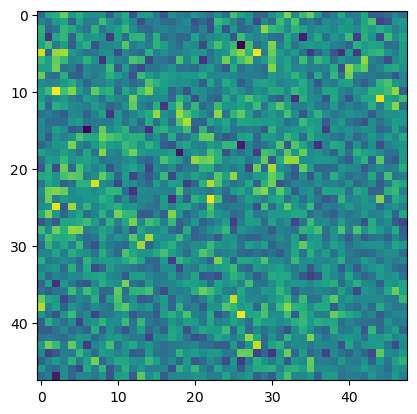

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(true_field1[0][0][0])

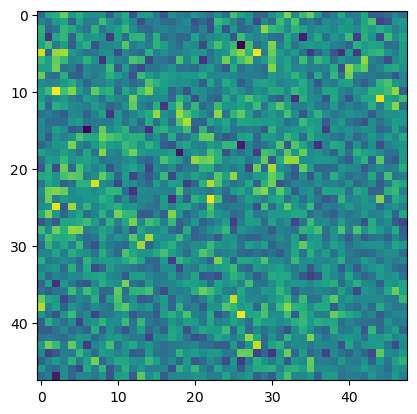

: 

In [6]:
import matplotlib.pyplot as plt
plt.imshow(true_field2[0][0][0])

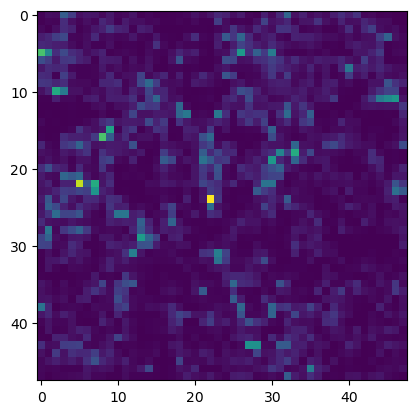

In [ ]:
plt.imshow(input_halo[0][0][0]);